In [1]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from scipy.interpolate import interp2d
from skimage.filters import try_all_threshold
import matplotlib.pyplot as plt
import cv2
from utils.data_preparation import extract_part
from utils.data_preparation import extract_all
from utils.data_preparation import create_mask
from utils.data_preparation import extract_time
from utils.data_preparation import extract_single

# Data Extraction and Annotation
Code to extract images from netCDF4 data for inspection, training image selection, and annotation. The second part of this notebook creates edge maps that can be used as starting points for annotation. The entire annotation procedure is described in ```docs/annotation.pdf```.

In [2]:
# specify flight number
flight = 9

# replace data paths, e.g.:
nc_flight9 = 'E:/polar/code/data/flight9/IRdata_ATWAICE_processed_220718_142920.nc'

# insert absolute path to folder where to save images
save_path = None

### Data Loading
Load netCDF4 files and convert relevant variables to numpy arrays: temperature values and timestamps (for identification). Later, xd and yd are used to bring the data to the right grid.

In [3]:
# load only one flight at a time due to memory constraints
ds = netCDF4.Dataset(nc_flight9)

In [4]:
ds_size = len(ds.dimensions['t'])

imgs = ds.variables['Ts'][:]

xd = ds.variables['xd'][:]
yd = ds.variables['yd'][:]

timestamps = ds.variables['time'][:]

print(imgs.shape)
print(type(imgs))

(4989, 480, 640)
<class 'numpy.ma.core.MaskedArray'>


### Metadata Inspection
Inspect additional information contained in the data.

In [5]:
print(ds)
print(ds.variables['altitude'])
print(ds.variables['lon'])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Title: UB IR Camera images
    Institution: University of Bremen
    PI_name: Dr. Gunnar Spreen
    Product_name: Thermal infrared sea ice surface temperature images
    Description: This data is processed during the PS131 ATWAICE Campaign.
    Date: 2022-07-18 00:00:00
    dimensions(sizes): x(480), y(640), t(4989)
    variables(dimensions): |S1 crs(), float32 Ts(t, x, y), float32 lon(t), float32 lat(t), float32 time(t), float32 roll(t), float32 pitch(t), float32 altitude(t), float32 ix(t), float32 heading(t), float32 mss(t), float32 xd(t, x, y), float32 yd(t, x, y), float32 grad(x, y)
    groups: 
<class 'netCDF4._netCDF4.Variable'>
float32 altitude(t)
    units: m
    standard_name: Altitude
unlimited dimensions: 
current shape = (4989,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(t)
    units: degrees_east
    standard_name: long

### Save Images
To get a better overview over the data, store images on local disk. Some data may not suit as training data due to bad visibility, manual inspection allows for preselection. The function ```extract_all``` extracts all images, the function ```extract_part``` extracts only those without a spatial overlap. Select your desired function with regard to memory constraints.

In [ ]:
extract_part(imgs, ds_size, timestamps, flight, save_path)

In [ ]:
extract_all(imgs, ds_size, timestamps, flight, save_path)

### Edge Detection
Create edge masks as starting point for annotation.
Images are resized to a shape of (2345,2345) because this allows finer masks. This is not optimal because it can imply interpolation errors. Masks must be resized to (460,460) later to match the input images.
For the current annotation procedure, edge maps are not used anymore, so resizing is not included in the preprocessing pipeline (```preprocessing_sample.ipynb```).

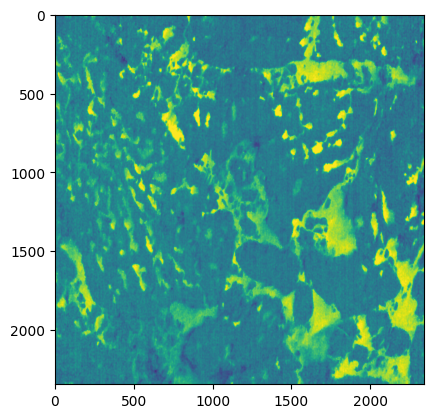

In [7]:
# replace image path
img = cv2.imread('E:/polar/Flight9/ir_four//20220718_150322_427.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img = resize(img, (2345,2345))
plt.imshow(img)

# potentially save resized image to align it with edge mask for annotation
#plt.imsave('E:/test/potential_ir/1024_orig_size.png', img, cmap='cividis')

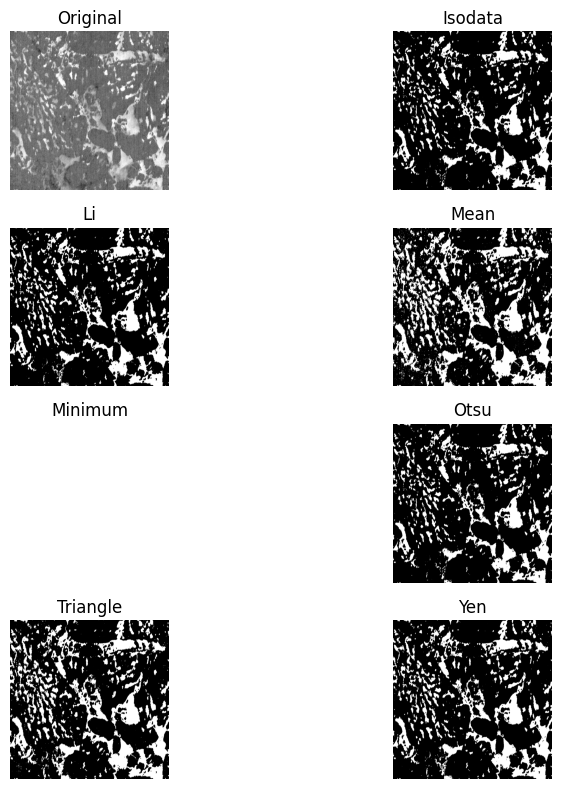

In [8]:
# plot different thresholding methods to choose which works best
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

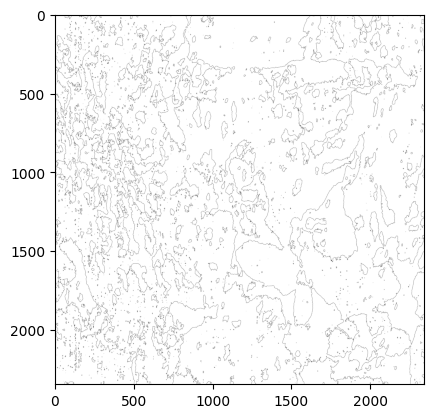

In [9]:
# possible threshold methods are 'li', 'otsu' and 'mean'. Others can be implemented
create_mask(img, threshold='mean')